# Data Pre-processing

# RQ1. 중1 학생들의 수면 시간에 큰 영향을 미치는 요소에는 무엇이 있을까?

In [1]:
import pandas as pd
import numpy as np
import csv
from statsmodels import api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
f = open('codebook.csv','r')
rdr = csv.reader(f)
code_dict = {}
for line in rdr:
    code_dict[line[6]] = line[:6]

# Read data

한국아동청소년패널조사(KCYPS) 2018의 중1 코호트 2차 조사(2019년) 데이터를 활용하였다. 본 조사는 중학교 1학년 학생 2438명을 대상으로 진행되었으며, 학습시간, 여가시간, 신체증상, 행복감, 친구관계, 현실비행 경험 유무 및 빈도 등과 관련된 문항 총 378개로 구성되어 있다. 

In [3]:
# read data
df = pd.read_csv('./data/KCYPS2018m1w2[CSV]/KCYPS2018m1Yw2.csv')
df

,HID,PID,SCLIDw2,WEIGHTA1w2,WEIGHTA2w2,WEIGHTB1w2,WEIGHTB2w2,SURVEY1w2,SURVEY2w2,COHORTw2,...,YDLQ2A12w2,YDLQ2A13w2,YDLQ2A14w2,YDLQ2A15w2,YPHY1A00w2,YPHY1B00w2,YPHY1C00w2,YPHY2A00w2,YPHY2B00w2,YPHY2C00w2
0,780,2,20409,214.693708609272,1.260686727224,215.721347394929,1.2667210473997,1,1,m1,...,1,1,1,1,2,3,7,163,56,1
1,1192,2,20912,87.6273251058101,.514549804084321,87.9315523040103,.516336233660278,1,1,m1,...,1,1,1,1,3,2,6,165,40,5
2,1193,2,40920,105.83496049671,.621465486058106,105.583650039588,.619989784884755,1,1,m1,...,1,1,1,1,4,3,7,170,50,6
3,1285,2,20920,281.283010983134,1.65170074538796,280.220791250769,1.64546336504429,1,1,m1,...,1,1,1,1,3,4,7,162,40,7
4,1590,2,20936,83.6442648737278,.491161176625942,83.1256287182711,.488115732389695,1,1,m1,...,1,1,1,1,3,2,7,156,49,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,5157,1,21703,260.64,1.53048447815332,244.89075549328,1.43800452779967,1,1,m1,...,1,1,1,1,3,5,2,160,49,1
2586,5158,1,21703,260.64,1.53048447815332,226.303637303806,1.32886051351716,1,1,m1,...,1,1,1,1,3,3,7,172,62,1
2587,5159,1,21703,260.64,1.53048447815332,244.89075549328,1.43800452779967,1,1,m1,...,1,1,1,1,3,3,2,171,61,6
2588,5160,1,21703,260.64,1.53048447815332,244.89075549328,1.43800452779967,1,1,m1,...,1,1,1,1,4,4,7,156,47,6


# Preprocessing X and Y

연구 질문에 따른 종속 변수(Y)를 설정하기 위하여 수면시간과 관련된 문항 8개를 바탕으로 일평균 수면시간(분)을 산출하였다. 독립 변수(X)는 총 378개의 문항 중, 종속 변수로 선택한 8개의 문항, 학교코드, 생년 등 연구 질문과 관련 없는 17개 문항, 그리고 응답에 결측치가 포함된 71개 문항을 제외하고 남은 282개 문항으로 설정하였다. 문항에 대한 응답은 객관식인 경우 리커르트 척도(1: 전혀 그렇지 않다, 4: 매우 그렇다)로 측정되었고, 주관식의 경우 범주가 없는 개방형 숫자로 측정되었다.

In [4]:
# pre-processing
idx_drop = df[df['SURVEY1w2']==2].index # delete rows which fails to get survey result
df.drop(idx_drop,inplace=True)

df.drop(df.columns[:11],inplace=True,axis=1)
df.drop(df.columns[-3:],inplace=True,axis=1)
df.drop(['ARA1Bw2','YBRT1Aw2','YBRT1Bw2'],inplace=True,axis=1)

df.replace(' ',np.NaN,inplace=True) 

df.dropna(axis=1,inplace=True) # delete columns which has a blank value

df = df.astype(int)

y = (((df['YTIM1A01w2']-df['YTIM1B01w2']+24)*60+(60+df['YTIM1A02w2']-df['YTIM1B02w2'])%60) * 5 +
    ((df['YTIM1A03w2']-df['YTIM1B03w2']+24)*60+(60+df['YTIM1A04w2']-df['YTIM1B04w2'])%60) * 2) /7
df.drop(df.columns[3:7], inplace=True, axis=1) # get a sleeptime from data
x = df.drop(df.columns[4:8],axis=1) # delete sleeptime from df and make x

In [5]:
x =(x- x.mean())/x.std()

In [6]:
y

0       608.571429
1       514.285714
2       582.857143
3       561.428571
4       544.285714
           ...    
2584    517.142857
2585    450.000000
2586    555.714286
2587    540.000000
2588    508.571429
Length: 2438, dtype: float64

# Modeling

## Forward Selection

In [7]:
variables = x.columns.tolist() ## 설명 변수 리스트

selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
best_step = 0
max_adjusted_r_squared = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        temp_model = sm.OLS(y,sm.add_constant(x[selected_variables])).fit()
        adj_r_squared = temp_model.rsquared_adj
        if adj_r_squared > max_adjusted_r_squared:
            best_model = temp_model
            best_step = step
            max_adjusted_r_squared = adj_r_squared
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
sv_forward = sv_per_step[best_step-1]
model_forward = best_model

In [9]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     17.90
Date:                Thu, 18 Mar 2021   Prob (F-statistic):          1.71e-145
Time:                        18:16:32   Log-Likelihood:                -13047.
No. Observations:                2438   AIC:                         2.621e+04
Df Residuals:                    2379   BIC:                         2.655e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        509.5236      1.046    486.923      0.000     507.472     511.576
YTIM1K01w2    -8.7153      1.672     -5.211      0.000     -11.995      -5.436
YTIM1M01w2     2.8588      1.599      1.787      0.074      -0.278       5.995
YFAM1A04w2     4.5526      1.250      3.641      0.000       2.101       7.005
YTIM1C01w2     6.1744      1.440      4.287      0.000       3.350       8.998
YTIM1H02w2    -7.7040      1.292     -5.961      0.000     -10.238      -5.170
YINT2B04w2     2.8393      1.293      2.196      0.028       0.303       5.375
YTIM1G02w2     3.9260      1.262      3.110      0.002       1.451       6.401
YTIM1E02w2    -4.4456      1.248     -3.563      0.000      -6.892      -1.999
YTIM1I02w2     3.0007      1.244      2.412      0.016       0.561       5.440
YFUR1B00w2    -2.7788      1.117     -2.487      0.013      -4.970      -0.588
YGENDERw2     -5.1825      1.173     -4.419      0.000      -7.482      -2.883
YPSY6A30w2    -3.3046      1.111     -2.975      0.003      -5.483      -1.126
YFAM2F04w2     2.8099      1.329      2.114      0.035       0.203       5.417
YFUR2A02w2     2.9018      1.104      2.629      0.009       0.738       5.066
YPSY5A11w2    -5.6233      1.288     -4.365      0.000      -8.149      -3.097
YTIM1D02w2     4.8983      1.200      4.083      0.000       2.546       7.251
YPSY7A01w2    -5.0265      1.243     -4.042      0.000      -7.465      -2.588
YPSY4C01w2     5.3720      1.296      4.144      0.000       2.830       7.914
YPHY1B00w2    -4.0634      1.175     -3.460      0.001      -6.367      -1.760
YDLQ1A06w2     9.5031      1.677      5.667      0.000       6.215      12.791
YDLQ1A02w2    -2.4368      1.705     -1.429      0.153      -5.781       0.907
YPSY4C07w2    -4.0439      1.307     -3.093      0.002      -6.607      -1.480
YPSY7A06w2     3.6226      1.222      2.963      0.003       1.225       6.020
YEDU2A06w2     5.7284      1.275      4.494      0.000       3.229       8.228
YEDU2A01w2    -3.3059      1.232     -2.683      0.007      -5.722      -0.890
YEDU3A05w2    -4.0831      1.303     -3.134      0.002      -6.638      -1.528
YPSY5A05w2     3.8545      1.283      3.003      0.003       1.338       6.371
YPSY6A21w2    -3.5162      1.100     -3.195      0.001      -5.674      -1.358
YPSY6A20w2     4.6875      1.117      4.196      0.000       2.497       6.878
YTIM1C02w2     4.4745      1.419      3.153      0.002       1.692       7.257
YFAM2F01w2     3.3042      1.235      2.675      0.008       0.882       5.726
YPHY1C00w2     3.3748      1.143      2.952      0.003       1.133       5.617
YTIM1E01w2    -2.9889      1.202     -2.486      0.013      -5.346      -0.631
YPSY4B02w2     3.6126      1.271      2.842      0.005       1.120       6.105
YINT2A08w2     2.0650      1.366      1.511      0.131      -0.614       4.745
YI

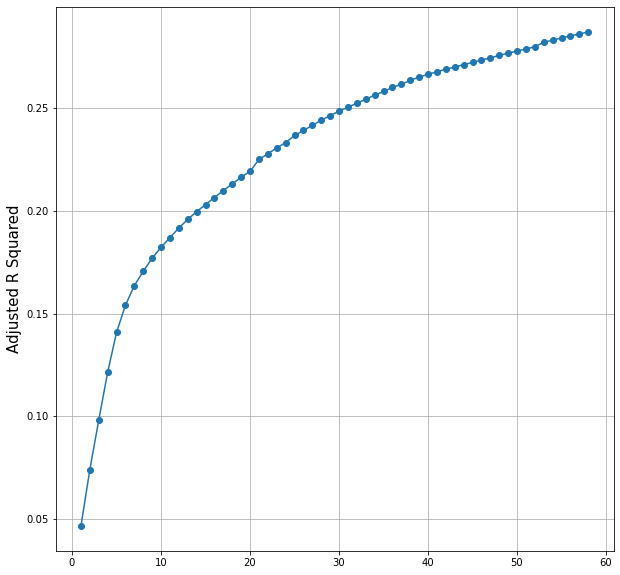

In [11]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')

font_size = 15
# plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')

plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

## Backward Selection

In [12]:
# Backward Elimination 후진 소거법
variables = x.columns.tolist() ## 설명 변수 리스트

selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05

sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
best_step = 0
max_adjusted_r_squared = 0

while len(selected_variables) > 0:
    X = sm.add_constant(x[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)

        step += 1
        steps.append(step)
        temp_model = sm.OLS(y,sm.add_constant(x[selected_variables])).fit()
        adj_r_squared = temp_model.rsquared_adj
        if adj_r_squared > max_adjusted_r_squared:
            best_model = temp_model
            best_step = step
            max_adjusted_r_squared = adj_r_squared
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
sv_backward = sv_per_step[best_step-1]
model_backward = best_model

In [14]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     9.385
Date:                Thu, 18 Mar 2021   Prob (F-statistic):          2.83e-138
Time:                        18:16:52   Log-Likelihood:                -12957.
No. Observations:                2438   AIC:                         2.618e+04
Df Residuals:                    2303   BIC:                         2.697e+04
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        509.5236      1.025    497.032      0.000     507.513     511.534
ARA2Aw2        1.4456      1.087      1.330      0.184      -0.686       3.577
YGENDERw2     -5.4157      1.322     -4.096      0.000      -8.008      -2.823
YTIM1C01w2     6.4711      1.454      4.452      0.000       3.621       9.322
YTIM1C02w2     4.4725      1.419      3.152      0.002       1.690       7.255
YTIM1D02w2     5.3408      1.216      4.393      0.000       2.957       7.725
YTIM1E01w2    -2.7918      1.223     -2.283      0.023      -5.190      -0.394
YTIM1E02w2    -4.3667      1.247     -3.501      0.000      -6.813      -1.921
YTIM1F02w2    -1.6024      1.180     -1.358      0.175      -3.916       0.711
YTIM1G01w2     3.1725      1.320      2.404      0.016       0.585       5.760
YTIM1G02w2     2.8248      1.416      1.995      0.046       0.048       5.602
YTIM1H01w2    -3.7952      1.592     -2.385      0.017      -6.916      -0.674
YTIM1H02w2    -5.2678      1.621     -3.249      0.001      -8.447      -2.089
YTIM1I01w2     3.2455      1.283      2.530      0.011       0.730       5.761
YTIM1J01w2    -2.5227      1.571     -1.605      0.109      -5.604       0.559
YTIM1J02w2     2.9141      1.476      1.974      0.049       0.019       5.810
YTIM1K01w2    -8.3155      1.720     -4.834      0.000     -11.689      -4.942
YTIM1K02w2    -5.1316      1.650     -3.110      0.002      -8.367      -1.896
YTIM1L01w2    -5.1641      1.720     -3.003      0.003      -8.537      -1.791
YTIM1L02w2     3.1794      1.706      1.863      0.063      -0.167       6.525
YTIM1M01w2     2.6330      1.629      1.616      0.106      -0.562       5.828
YTIM1M02w2     3.5561      1.566      2.270      0.023       0.484       6.628
YTIM1N01w2     1.6442      1.235      1.332      0.183      -0.777       4.065
YMDA1A00w2    -1.7134      1.139     -1.504      0.133      -3.947       0.521
YACT1A05w2     2.1921      1.220      1.797      0.073      -0.201       4.585
YACT1A06w2     1.8651      1.293      1.442      0.149      -0.671       4.401
YACT1A09w2     1.5584      1.261      1.236      0.217      -0.915       4.031
YACT2A01w2     2.4133      1.132      2.132      0.033       0.193       4.633
YACT2A02w2    -3.0455      1.179     -2.584      0.010      -5.357      -0.734
YEDU1A00w2    -2.0080      1.266     -1.586      0.113      -4.491       0.475
YINT2A01w2    -2.6278      1.382     -1.902      0.057      -5.338       0.082
YINT2A02w2    -2.4540      1.422     -1.725      0.085      -5.243       0.335
YINT2A05w2    -2.1671      1.907     -1.136      0.256      -5.906       1.572
YINT2A06w2     3.0257      2.035      1.487      0.137      -0.966       7.017
YINT2A07w2     2.2688      1.838      1.235      0.217      -1.335       5.872
YINT2A08w2     1.7859      1.414      1.263      0.207      -0.987       4.558
YI

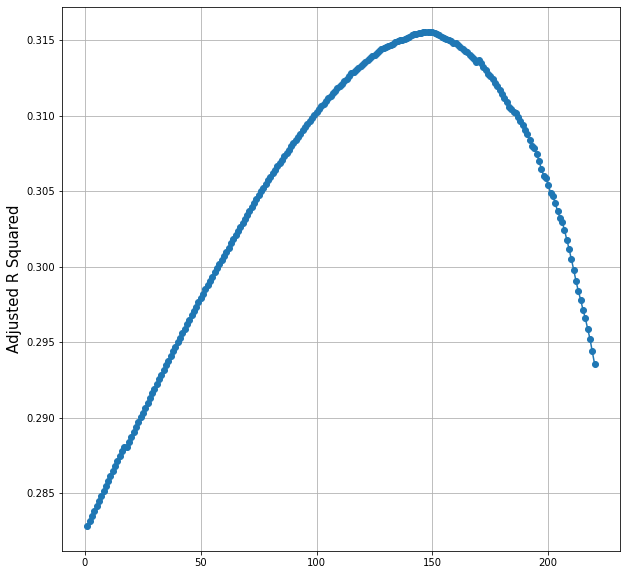

In [16]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')

font_size = 15
# plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')

plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

## Stepwise selection

In [17]:
# Stepwise Selection 단계별 선택법
variables = x.columns.tolist() ## 설명 변수 리스트

selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05

sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
best_step = 0
max_adjusted_r_squared = 0

while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = x[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]

    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = x[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break

        step += 1
        steps.append(step)
        temp_model = sm.OLS(y,sm.add_constant(x[selected_variables])).fit()
        adj_r_squared = temp_model.rsquared_adj
        if adj_r_squared > max_adjusted_r_squared:
            best_model = temp_model
            best_step = step
            max_adjusted_r_squared = adj_r_squared
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
sv_stepwise = sv_per_step[best_step-1]
model_stepwise = best_model

In [19]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     18.32
Date:                Thu, 18 Mar 2021   Prob (F-statistic):          5.95e-147
Time:                        18:18:32   Log-Likelihood:                -13045.
No. Observations:                2438   AIC:                         2.621e+04
Df Residuals:                    2380   BIC:                         2.654e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        509.5236      1.045    487.436      0.000     507.474     511.573
YTIM1K01w2    -8.5329      1.642     -5.198      0.000     -11.752      -5.314
YFAM1A04w2     4.2866      1.254      3.417      0.001       1.827       6.746
YTIM1C01w2     6.4529      1.438      4.487      0.000       3.633       9.273
YTIM1H02w2    -7.2631      1.291     -5.625      0.000      -9.795      -4.731
YTIM1G02w2     3.1767      1.392      2.282      0.023       0.447       5.906
YTIM1E02w2    -4.6868      1.241     -3.775      0.000      -7.121      -2.252
YTIM1I02w2     3.1807      1.248      2.548      0.011       0.733       5.629
YFUR1B00w2    -2.5573      1.123     -2.278      0.023      -4.759      -0.356
YGENDERw2     -5.4750      1.164     -4.702      0.000      -7.758      -3.192
YPSY6A30w2    -3.4648      1.109     -3.126      0.002      -5.639      -1.291
YFAM2F04w2     2.9853      1.312      2.276      0.023       0.413       5.557
YFUR2A02w2     2.9956      1.094      2.738      0.006       0.850       5.141
YPSY5A11w2    -4.8904      1.325     -3.692      0.000      -7.488      -2.293
YTIM1D02w2     4.8525      1.179      4.115      0.000       2.540       7.165
YPSY7A01w2    -5.2791      1.240     -4.257      0.000      -7.711      -2.847
YPSY4C01w2     5.5116      1.292      4.266      0.000       2.978       8.045
YPHY1B00w2    -4.4750      1.168     -3.832      0.000      -6.765      -2.185
YDLQ1A06w2     7.8499      1.714      4.580      0.000       4.489      11.211
YPSY4C07w2    -4.2625      1.306     -3.263      0.001      -6.824      -1.701
YPSY7A06w2     3.6711      1.222      3.005      0.003       1.275       6.067
YEDU2A06w2     5.6845      1.277      4.453      0.000       3.181       8.188
YEDU2A01w2    -2.9457      1.219     -2.416      0.016      -5.337      -0.555
YEDU3A05w2    -3.6349      1.300     -2.796      0.005      -6.185      -1.085
YPSY5A05w2     4.8905      1.300      3.761      0.000       2.340       7.441
YPSY6A21w2    -3.9373      1.099     -3.582      0.000      -6.093      -1.782
YPSY6A20w2     4.2793      1.115      3.837      0.000       2.093       6.466
YTIM1C02w2     4.3168      1.417      3.047      0.002       1.538       7.095
YFAM2F01w2     3.6960      1.218      3.033      0.002       1.307       6.085
YPHY1C00w2     3.4378      1.138      3.022      0.003       1.207       5.669
YTIM1E01w2    -3.0291      1.199     -2.527      0.012      -5.380      -0.678
YPSY4B02w2     3.5701      1.270      2.810      0.005       1.079       6.061
YINT2A08w2     3.3237      1.258      2.641      0.008       0.856       5.791
YINT2A01w2    -3.8794      1.257     -3.085      0.002      -6.345      -1.414
YPSY3A09w2    -4.2423      1.289     -3.291      0.001      -6.770      -1.714
YPSY4D02w2     4.0401      1.204      3.354      0.001       1.678       6.402
YF

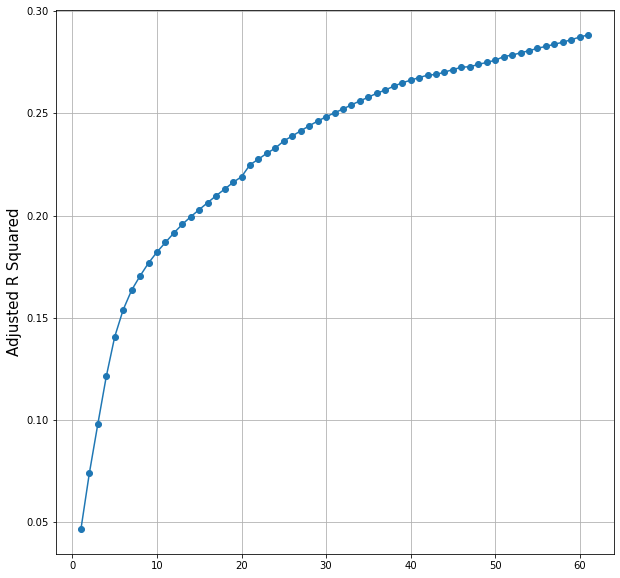

In [21]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')

font_size = 15
# plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')

plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

# Result

In [22]:
print("the number of variable at best model of forward selection:",len(sv_forward))
print("the number of variable at best model of backward selection:",len(sv_backward))
print("the number of variable at best model of stepwise selection:",len(sv_stepwise))

the number of variable at best model of forward selection: 58
the number of variable at best model of backward selection: 134
the number of variable at best model of stepwise selection: 57


In [55]:
print("the R2 score of variable at best model of forward selection: %.3f" % model_forward.rsquared_adj)
print("the R2 score of variable at best model of backward selection: %.3f" % model_backward.rsquared_adj)
print("the R2 score of variable at best model of stepwise selection: %.3f" % model_stepwise.rsquared_adj)

the R2 score of variable at best model of forward selection: 0.287
the R2 score of variable at best model of backward selection: 0.316
the R2 score of variable at best model of stepwise selection: 0.288


위 결과에서도 볼 수 있다시피, backward selection model이 가장 좋은 성능을 보여주었다. 하지만 R square 같은 경우는 Adjusted R square라고 하더라도 변수 수에 어느정도 영향을 받는다. 이를 감안했을 때, 변수 선택적인 측면에서 가장 좋은 결과를 보여주는 변수 축소 방식은 stepwise라고 할 수 있다.

# Ridge, Lasso, ElasticNet 평가

## Modeling

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3)
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

LinearRegression()

In [41]:
# Test set 성능 평가 방법2
r2_score(y_test, model.predict(X_test))

0.1439091096658196

In [42]:
# Let's predict

ridge_result = []
lasso_result = []
elastic_result = []
alpha = [0.001,0.01,0.1,1,10]
best_score = [0,0,0]
best_model = [0,0,0]
for a in alpha:
  ridge = Ridge(alpha=a, max_iter=10000000)
  lasso = Lasso(alpha=a, max_iter=10000000)
  elastic = ElasticNet(alpha=a, max_iter=10000000)

  ridge.fit(X_train,y_train)
  lasso.fit(X_train,y_train)
  elastic.fit(X_train,y_train)

  ridge_y_hat = ridge.predict(X_test)
  lasso_y_hat = lasso.predict(X_test)
  elastic_y_hat = elastic.predict(X_test)

  ridge_r2, lasso_r2, elastic_r2 = r2_score(y_test,ridge_y_hat), r2_score(y_test,lasso_y_hat), r2_score(y_test,elastic_y_hat)
  r2s = [ridge_r2,lasso_r2,elastic_r2]
  models = [ridge,lasso,elastic]
  for i in range(3):
        if r2s[i] > best_score[i]:
            best_score[i] = r2s[i]
            best_model[i] = models[i]
  ridge_result.append(ridge_r2)
  lasso_result.append(lasso_r2)
  elastic_result.append(elastic_r2)

## Result

In [56]:
sv_lasso = []
for i, c in enumerate(best_model[1].coef_):
    if c != 0:
        sv_lasso.append(x.columns[i])
sv_en = []
for i, c in enumerate(best_model[2].coef_):
    if c != 0:
        sv_en.append(x.columns[i])

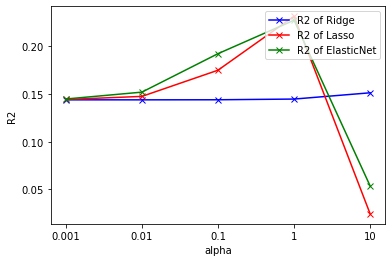

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(5), ridge_result, '-x', c='blue', label="R2 of Ridge")
ax.plot(range(5), lasso_result, '-x', c='red', label="R2 of Lasso")
ax.plot(range(5), elastic_result, '-x', c='green', label="R2 of ElasticNet")
plt.xticks(range(5), alpha)
plt.xlabel('alpha')
plt.ylabel('R2')
plt.legend(loc='upper right')
plt.show()

In [58]:
print('the number of variable at best model of Lasso:',len(sv_lasso))
print('the number of variable at best model of ElasticNet:',len(sv_en))

the number of variable at best model of Lasso: 122
the number of variable at best model of ElasticNet: 195


In [59]:
print('the R2 score of variable at best model of Ridge: %.3f' % best_score[0])
print('the R2 score of variable at best model of Lasso: %.3f' % best_score[1])
print('the R2 score of variable at best model of ElasticNet: %.3f' % best_score[2])

the R2 score of variable at best model of Ridge: 0.151
the R2 score of variable at best model of Lasso: 0.232
the R2 score of variable at best model of ElasticNet: 0.227


우선 최적의 성능을 보여주는 모델에서 lasso의 경우 122개의 변수를 ElasticNet의 경우 195개의 변수를 선택했다.

위 그래프에서도 알 수 있듯이 penalty parameter가 너무 커지는 경우를 제외하고는 Lasso와 Elastic Net이 Ridge보다 좋은 성능을 보여주고 있다. Lasso와 Elastic Net은 그래프 상에서는 Elastic Net이 근소하게 좋은 성능을 보여주고 있지만, 최고의 성능을 보여주는 지표에서의 R squared 값은 Lasso가 앞서고 있다. 그렇기에 앞으로 해당 기법을 활용해 변수를 축소선택하면 양 모델을 모두 설계한 후 그 결과를 비교하는 형식으로 진행해야 할 것 같다.

In [47]:
sv_forward_dict = {}
for sv in sv_forward:
    code = code_dict[sv[:-2]][2]
    if sv_forward_dict.get(code) is None:
        sv_forward_dict[code] = 1
    else:
        sv_forward_dict[code] += 1
sorted(sv_forward_dict.items(), key=lambda x: x[1], reverse=True)

[('[하루일과]', 12),
 ('[학업태도]', 6),
 ('[창의성]', 6),
 ('[정서문제]', 5),
 ('[양육태도]', 4),
 ('[비행Ⅰ]', 4),
 ('[교사]', 3),
 ('[부모관계]', 2),
 ('[진로관]', 2),
 ('[협동의식]', 2),
 ('[끈기]', 2),
 ('[건강]', 2),
 ('[친구]', 2),
 ('[자아인식]', 2),
 ('[진로계획]', 1),
 ('-', 1),
 ('[청소년 활동]', 1),
 ('[행복]', 1)]

In [48]:
sv_backward_dict = {}
for sv in sv_backward:
    code = code_dict[sv[:-2]][2]
    if sv_backward_dict.get(code) is None:
        sv_backward_dict[code] = 1
    else:
        sv_backward_dict[code] += 1
sorted(sv_backward_dict.items(), key=lambda x: x[1], reverse=True)

[('[하루일과]', 20),
 ('[학업태도]', 18),
 ('[정서문제]', 16),
 ('[창의성]', 13),
 ('[양육태도]', 9),
 ('[비행Ⅱ]', 9),
 ('[교사]', 7),
 ('[비행Ⅰ]', 7),
 ('[협동의식]', 4),
 ('[친구]', 4),
 ('[청소년 활동]', 3),
 ('[진로관]', 3),
 ('[자아인식]', 3),
 ('[끈기]', 3),
 ('-', 2),
 ('[동아리 활동]', 2),
 ('[행복]', 2),
 ('[부모관계]', 2),
 ('[건강]', 2),
 ('[스마트폰]', 1),
 ('[학교생활]', 1),
 ('[진로계획]', 1),
 ('[만족도]', 1),
 ('[형제자매]', 1)]

In [49]:
sv_stepwise_dict = {}
for sv in sv_stepwise:
    code = code_dict[sv[:-2]][2]
    if sv_stepwise_dict.get(code) is None:
        sv_stepwise_dict[code] = 1
    else:
        sv_stepwise_dict[code] += 1
sorted(sv_stepwise_dict.items(), key=lambda x: x[1], reverse=True)

[('[하루일과]', 12),
 ('[창의성]', 6),
 ('[정서문제]', 5),
 ('[학업태도]', 5),
 ('[협동의식]', 3),
 ('[비행Ⅰ]', 3),
 ('[교사]', 3),
 ('[비행Ⅱ]', 3),
 ('[부모관계]', 2),
 ('[양육태도]', 2),
 ('[진로관]', 2),
 ('[끈기]', 2),
 ('[건강]', 2),
 ('[친구]', 2),
 ('[진로계획]', 1),
 ('-', 1),
 ('[자아인식]', 1),
 ('[스마트폰]', 1),
 ('[청소년 활동]', 1)]

In [50]:
sv_lasso_dict = {}
for sv in sv_lasso:
    code = code_dict[sv[:-2]][2]
    if sv_lasso_dict.get(code) is None:
        sv_lasso_dict[code] = 1
    else:
        sv_lasso_dict[code] += 1
sorted(sv_lasso_dict.items(), key=lambda x: x[1], reverse=True)

[('[하루일과]', 18),
 ('[창의성]', 15),
 ('[학업태도]', 14),
 ('[정서문제]', 14),
 ('[양육태도]', 10),
 ('[협동의식]', 6),
 ('[교사]', 5),
 ('[청소년 활동]', 4),
 ('[자아인식]', 4),
 ('[친구]', 4),
 ('[비행Ⅰ]', 4),
 ('[비행Ⅱ]', 4),
 ('-', 3),
 ('[진로관]', 3),
 ('[동아리 활동]', 2),
 ('[행복]', 2),
 ('[끈기]', 2),
 ('[부모관계]', 2),
 ('[건강]', 2),
 ('[스마트폰]', 1),
 ('[진로계획]', 1),
 ('[만족도]', 1),
 ('[형제자매]', 1)]

In [51]:
sv_en_dict = {}
for sv in sv_en:
    code = code_dict[sv[:-2]][2]
    if sv_en_dict.get(code) is None:
        sv_en_dict[code] = 1
    else:
        sv_en_dict[code] += 1
sorted(sv_en_dict.items(), key=lambda x: x[1], reverse=True)

[('[창의성]', 27),
 ('[정서문제]', 24),
 ('[하루일과]', 20),
 ('[학업태도]', 20),
 ('[양육태도]', 19),
 ('[협동의식]', 10),
 ('[교사]', 10),
 ('[비행Ⅱ]', 8),
 ('[청소년 활동]', 7),
 ('[진로관]', 7),
 ('[자아인식]', 6),
 ('[끈기]', 6),
 ('[친구]', 6),
 ('[비행Ⅰ]', 4),
 ('-', 3),
 ('[행복]', 3),
 ('[부모관계]', 3),
 ('[건강]', 3),
 ('[동아리 활동]', 2),
 ('[만족도]', 2),
 ('[스마트폰]', 1),
 ('[팬덤 활동]', 1),
 ('[학업성취]', 1),
 ('[진로계획]', 1),
 ('[형제자매]', 1)]

Ridge를 제외한 각 모델들이 채택한 변수들을 카테고리별로 분류한 후 정렬해보았다. 그 결과 공통적으로 하루일과, 창의성, 학업태도, 정서문제 4가지 종류의 변수들이 순서는 조금씩 다르더라도 상위권에 위치했다. 또한 결정계수가 0.2 ~ 0.3 사이로 생각한 것보다는 낮게 나와서 모델의 문제가 있는 줄 알았으나, Cohen[1]에 의하면 사회과학의 경우 0.3 이상의 결정계수를 추천한다고 한다. 특히, 데이터의 크기에 따라 중간 크기의 데이터는 0.13, 큰 크기의 데이터는 0.3을 기준으로 상관관계가 어느정도 효과가 있음을 시사하고 있다. 이러한 점과 각 모델들이 선택한 변수들의 유형이 어느정도 일치한다는 점으로 보아 본 연구는 중학생의 수면시간에 영향을 끼치는 요소들을 유효하게 식별해냈다고 판단된다.

[1] Cohen, J.(1988), Statistical Power Analysis for the Behavioral Sciences(2nd Ed.), Lawrence Erlbaum Associates, Inc.